<a href="https://colab.research.google.com/github/roo-21/facepainting-gan/blob/main/face_paint_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_visible_devices(gpus, 'GPU')

In [4]:
images=np.load('/drive/MyDrive/Datasets/images/images.npy')
images=(images/127.5)-1
images.shape

(6200, 128, 128, 3)

In [5]:
images_blur=np.load('/drive/MyDrive/Datasets/images/images_blurred.npy') #images where the face is kept un-blurred while everything else is blurred
images_blur=(images_blur/127.5)-1
images_blur.shape

(6095, 128, 128, 3)

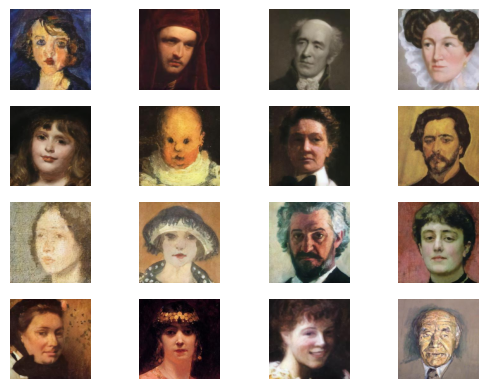

In [6]:
i=0
for j in np.random.randint(0,images.shape[0],16):
    plt.subplot(4, 4,i+1)
    plt.imshow((images[j]+1)/2)
    plt.axis("off")
    i+=1
plt.show()

In [7]:
img_shape=images.shape[1:]
latent_dim=100
img_shape

(128, 128, 3)

In [41]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, Flatten, Reshape, MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam

In [42]:
def create_discriminator(in_shape=img_shape):

    disc=Sequential()

    disc.add(Conv2D(128,(5,5), padding='same', input_shape=in_shape))
    disc.add(LeakyReLU(0.2))

    disc.add(Conv2D(128,(5,5),padding='same'))
    disc.add(LeakyReLU(0.2))
    disc.add(AveragePooling2D(2,2)) #output size=input shape/2 -> 64x64

    disc.add(Conv2D(128,(5,5),padding='same'))
    disc.add(LeakyReLU(0.2))
    disc.add(AveragePooling2D(2,2)) #output size=input shape/4 -> 32x32

    disc.add(Conv2D(128,(5,5),padding='same'))
    disc.add(LeakyReLU(0.2))
    disc.add(AveragePooling2D(2,2)) #output size=input shape/8 -> 16x16

"""    disc.add(Conv2D(128,(5,5),padding='same'))
    disc.add(LeakyReLU(0.2))
    disc.add(AveragePooling2D(2,2)) #output size=input shape/8 -> 8x8"""

    disc.add(Flatten())
    disc.add(Dropout(0.2))
    disc.add(Dense(1,activation='sigmoid'))

    disc.compile(loss='binary_crossentropy',optimizer=Adam(0.0001,0.6),metrics=['accuracy'])

    return disc

In [43]:
def create_generator(latent_dim=latent_dim):

    noise_shape=(latent_dim,)

    gen=Sequential()

    gen.add(Dense((16*16*256), input_shape=noise_shape))
    gen.add(LeakyReLU(0.2))

    gen.add(Reshape((16,16,256)))

    gen.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    gen.add(LeakyReLU(0.2))

    gen.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same',use_bias=False))
    gen.add(LeakyReLU(0.2))

    gen.add(Conv2DTranspose(128,(5,5),strides=(2,2), padding='same',use_bias=False))
    gen.add(LeakyReLU(0.2))
    gen.add(Dropout(0.3))

    gen.add(Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh',use_bias=False))

    return gen

In [45]:
def create_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0001,0.70))
  return model

In [12]:
def real_samples(dataset,num_samples):
  idx=np.random.randint(0,dataset.shape[0],num_samples)
  x=dataset[idx]
  y=np.ones((num_samples,1))

  return x,y

In [13]:
def generate_latent_points(latent_dim,num_samples):
  x_input = np.random.randn(num_samples,latent_dim)
  return x_input

In [14]:
def generate_fake_samples(generator,latent_dim,num_samples):
  x_input=generate_latent_points(latent_dim,num_samples)
  x=generator.predict(x_input)
  y=np.zeros((num_samples,1))
  return x,y

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=10,batch_size=32,vec=None):

  batch_per_epoch=int(dataset.shape[0]/batch_size)
  half_batch=int(batch_size/2)

  #lists to store discriminator and gan losses
  d_losses=[]
  g_losses=[]

  print(f"{n_epochs} epochs and {batch_per_epoch} batches of size {batch_size} each epoch")
  for i in range(n_epochs):
    for j in range(batch_per_epoch):

      x_real,y_real=real_samples(dataset,half_batch) # half the batch size of real images are taken during each batch and also they are labelled 1
      x_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch) # half the batch size of fake images are taken as well and the are labelled 0
      x_train=np.concatenate((x_real,x_fake),axis=0) # the real and fake images are concatenated
      y_train=np.concatenate((y_real,y_fake),axis=0) # and the labels too

      idx=np.random.permutation(x_train.shape[0]) # taking indices of the image array in random order
      x_train=x_train[idx] #shuffling the images and labels using the above order
      y_train=y_train[idx]

      d_loss,_=d_model.train_on_batch(x_train,y_train) #training the discriminator

      x_gan = generate_latent_points(latent_dim,batch_size) # latent vectors are generated for the gan model
      y_gan=np.ones((batch_size,1)) #they are all labelled 1

      g_loss = gan_model.train_on_batch(x_gan,y_gan) #training gan using the above data

      print('Epoch %d/%d, Batch %d/%d, d=%.3f g=%.3f' % (i+1, n_epochs, j+1, batch_per_epoch, d_loss, g_loss))

    if vec is not None:
        prediction=g_model.predict(vec)
        plt.imshow((np.array(prediction[0])+1)/2)
        plt.axis('off')
        plt.show()

    # appending discriminator loss and generator loss to the list after each epoch
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  g_model.save('face_painterdc1.h5')
  return d_losses,g_losses

In [46]:
discriminator=create_discriminator()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 128)     9728      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 128)     409728    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 average_pooling2d (Average  (None, 64, 64, 128)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 128)       409728    
                                                      

In [47]:
generator=create_generator(latent_dim)
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 65536)             6619136   
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 65536)             0         
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 128)       819200    
 Transpose)                                                      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 32, 32, 128)       409600    
 Transpose)                                           

In [48]:
vec0=np.random.randn(1,latent_dim)
img=generator.predict(vec0)

1/1 [==============================] - 0s 100ms/step


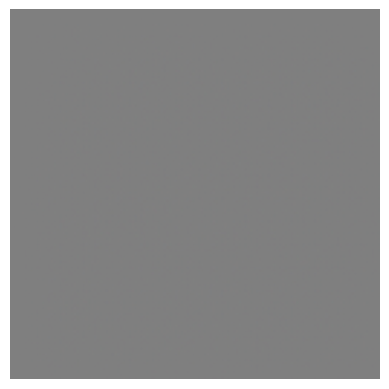

In [49]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [50]:
dcgan=create_gan(generator, discriminator)

In [51]:
epoch=50
batch_size=128

25 epochs and 48 batches of size 128 each epoch
2/2 [==============================] - 0s 18ms/step
Epoch 1/25, Batch 1/48, d=1.012 g=0.200
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 2/48, d=1.153 g=1.460
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 3/48, d=0.697 g=1.963
2/2 [==============================] - 0s 16ms/step
Epoch 1/25, Batch 4/48, d=0.720 g=1.048
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 5/48, d=0.616 g=0.720
2/2 [==============================] - 0s 14ms/step
Epoch 1/25, Batch 6/48, d=0.588 g=0.973
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 7/48, d=0.574 g=1.336
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 8/48, d=0.548 g=1.269
2/2 [==============================] - 0s 13ms/step
Epoch 1/25, Batch 9/48, d=0.575 g=1.253
2/2 [==============================] - 0s 14ms/step
Epoch 1/25, Batch 10/48, d=0.503 g=1.321
2/2 [==========================

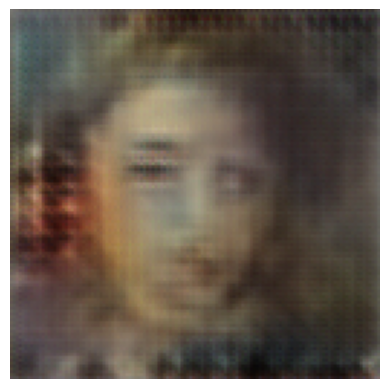

2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 1/48, d=0.516 g=1.390
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 2/48, d=0.514 g=1.378
2/2 [==============================] - 0s 14ms/step
Epoch 2/25, Batch 3/48, d=0.520 g=1.244
2/2 [==============================] - 0s 14ms/step
Epoch 2/25, Batch 4/48, d=0.552 g=1.140
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 5/48, d=0.519 g=1.169
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 6/48, d=0.470 g=1.408
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 7/48, d=0.618 g=1.269
2/2 [==============================] - 0s 14ms/step
Epoch 2/25, Batch 8/48, d=0.574 g=1.426
2/2 [==============================] - 0s 14ms/step
Epoch 2/25, Batch 9/48, d=0.613 g=1.662
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 10/48, d=0.608 g=0.821
2/2 [==============================] - 0s 13ms/step
Epoch 2/25, Batch 11/48, d=

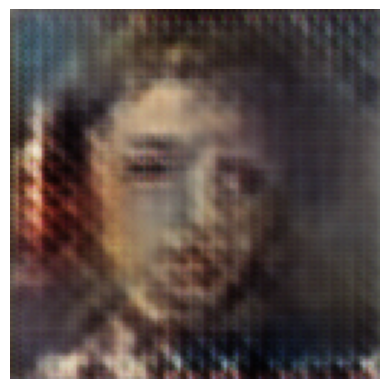

2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 1/48, d=0.501 g=1.209
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 2/48, d=0.480 g=1.150
2/2 [==============================] - 0s 14ms/step
Epoch 3/25, Batch 3/48, d=0.502 g=1.073
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 4/48, d=0.506 g=1.425
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 5/48, d=0.538 g=1.389
2/2 [==============================] - 0s 14ms/step
Epoch 3/25, Batch 6/48, d=0.544 g=1.062
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 7/48, d=0.612 g=1.145
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 8/48, d=0.598 g=1.226
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 9/48, d=0.583 g=1.076
2/2 [==============================] - 0s 14ms/step
Epoch 3/25, Batch 10/48, d=0.599 g=1.065
2/2 [==============================] - 0s 13ms/step
Epoch 3/25, Batch 11/48, d=

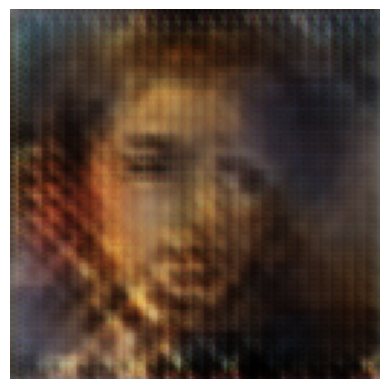

2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 1/48, d=0.493 g=1.315
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 2/48, d=0.479 g=1.467
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 3/48, d=0.503 g=0.973
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 4/48, d=0.502 g=1.544
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 5/48, d=0.476 g=1.243
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 6/48, d=0.448 g=1.003
2/2 [==============================] - 0s 13ms/step
Epoch 4/25, Batch 7/48, d=0.520 g=1.334
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 8/48, d=0.584 g=0.954
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 9/48, d=0.616 g=2.061
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 10/48, d=0.746 g=0.998
2/2 [==============================] - 0s 14ms/step
Epoch 4/25, Batch 11/48, d=

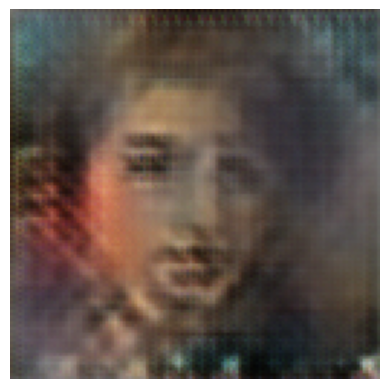

2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 1/48, d=0.580 g=1.185
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 2/48, d=0.570 g=1.390
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 3/48, d=0.496 g=1.274
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 4/48, d=0.478 g=1.084
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 5/48, d=0.524 g=1.550
2/2 [==============================] - 0s 13ms/step
Epoch 5/25, Batch 6/48, d=0.513 g=1.117
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 7/48, d=0.495 g=1.260
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 8/48, d=0.578 g=1.524
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 9/48, d=0.517 g=1.070
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 10/48, d=0.527 g=0.987
2/2 [==============================] - 0s 14ms/step
Epoch 5/25, Batch 11/48, d=

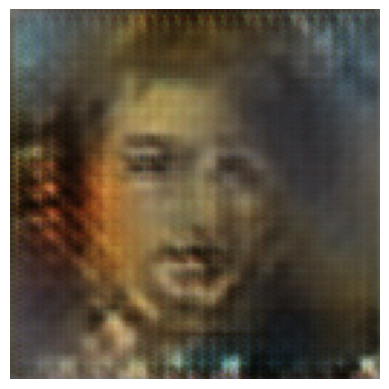

2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 1/48, d=0.466 g=1.248
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 2/48, d=0.480 g=1.408
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 3/48, d=0.453 g=1.230
2/2 [==============================] - 0s 13ms/step
Epoch 6/25, Batch 4/48, d=0.503 g=1.195
2/2 [==============================] - 0s 13ms/step
Epoch 6/25, Batch 5/48, d=0.472 g=1.352
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 6/48, d=0.447 g=1.195
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 7/48, d=0.497 g=1.068
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 8/48, d=0.505 g=1.242
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 9/48, d=0.500 g=1.504
2/2 [==============================] - 0s 14ms/step
Epoch 6/25, Batch 10/48, d=0.469 g=1.199
2/2 [==============================] - 0s 13ms/step
Epoch 6/25, Batch 11/48, d=

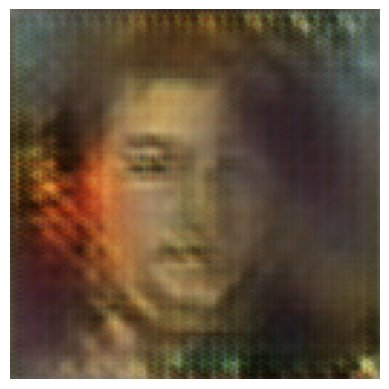

2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 1/48, d=0.411 g=1.439
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 2/48, d=0.422 g=1.078
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 3/48, d=0.435 g=1.446
2/2 [==============================] - 0s 13ms/step
Epoch 7/25, Batch 4/48, d=0.400 g=1.711
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 5/48, d=0.481 g=1.203
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 6/48, d=0.471 g=2.001
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 7/48, d=0.573 g=1.134
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 8/48, d=0.565 g=1.813
2/2 [==============================] - 0s 17ms/step
Epoch 7/25, Batch 9/48, d=0.457 g=1.601
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 10/48, d=0.520 g=1.029
2/2 [==============================] - 0s 14ms/step
Epoch 7/25, Batch 11/48, d=

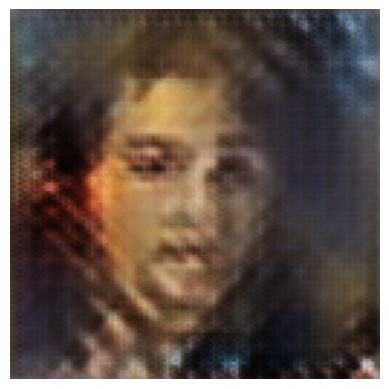

2/2 [==============================] - 0s 13ms/step
Epoch 8/25, Batch 1/48, d=0.593 g=1.362
2/2 [==============================] - 0s 13ms/step
Epoch 8/25, Batch 2/48, d=0.560 g=1.452
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 3/48, d=0.520 g=1.046
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 4/48, d=0.480 g=1.327
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 5/48, d=0.468 g=0.996
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 6/48, d=0.440 g=1.378
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 7/48, d=0.438 g=1.293
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 8/48, d=0.429 g=1.175
2/2 [==============================] - 0s 14ms/step
Epoch 8/25, Batch 9/48, d=0.461 g=1.527
2/2 [==============================] - 0s 13ms/step
Epoch 8/25, Batch 10/48, d=0.455 g=1.120
2/2 [==============================] - 0s 13ms/step
Epoch 8/25, Batch 11/48, d=

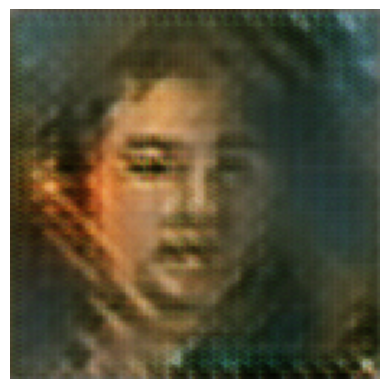

2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 1/48, d=0.451 g=1.664
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 2/48, d=0.403 g=1.146
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 3/48, d=0.396 g=1.870
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 4/48, d=0.402 g=1.200
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 5/48, d=0.446 g=2.034
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 6/48, d=0.374 g=1.117
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 7/48, d=0.510 g=2.774
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 8/48, d=0.738 g=1.090
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 9/48, d=0.636 g=1.105
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 10/48, d=0.481 g=2.144
2/2 [==============================] - 0s 14ms/step
Epoch 9/25, Batch 11/48, d=

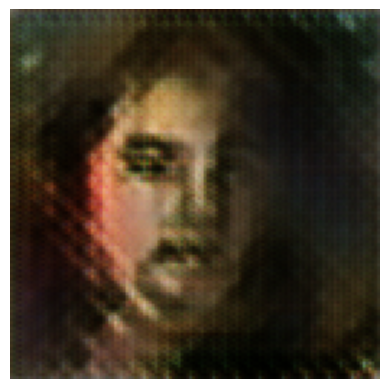

2/2 [==============================] - 0s 15ms/step
Epoch 10/25, Batch 1/48, d=0.545 g=0.967
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batch 2/48, d=0.521 g=1.510
2/2 [==============================] - 0s 13ms/step
Epoch 10/25, Batch 3/48, d=0.481 g=1.181
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batch 4/48, d=0.481 g=1.166
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batch 5/48, d=0.508 g=1.261
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batch 6/48, d=0.503 g=1.292
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batch 7/48, d=0.446 g=1.236
2/2 [==============================] - 0s 13ms/step
Epoch 10/25, Batch 8/48, d=0.445 g=1.470
2/2 [==============================] - 0s 13ms/step
Epoch 10/25, Batch 9/48, d=0.459 g=1.149
2/2 [==============================] - 0s 13ms/step
Epoch 10/25, Batch 10/48, d=0.489 g=1.852
2/2 [==============================] - 0s 14ms/step
Epoch 10/25, Batc

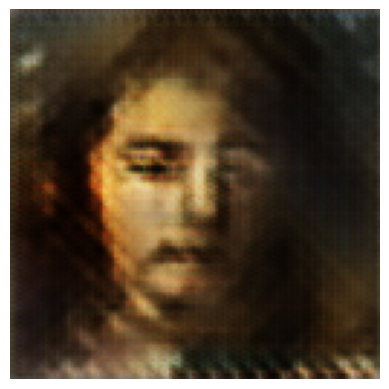

2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 1/48, d=0.509 g=2.067
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 2/48, d=0.454 g=1.553
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 3/48, d=0.513 g=0.804
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 4/48, d=0.476 g=1.500
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 5/48, d=0.505 g=1.610
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 6/48, d=0.514 g=0.857
2/2 [==============================] - 0s 13ms/step
Epoch 11/25, Batch 7/48, d=0.484 g=1.388
2/2 [==============================] - 0s 13ms/step
Epoch 11/25, Batch 8/48, d=0.534 g=1.191
2/2 [==============================] - 0s 15ms/step
Epoch 11/25, Batch 9/48, d=0.501 g=0.986
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batch 10/48, d=0.589 g=1.538
2/2 [==============================] - 0s 14ms/step
Epoch 11/25, Batc

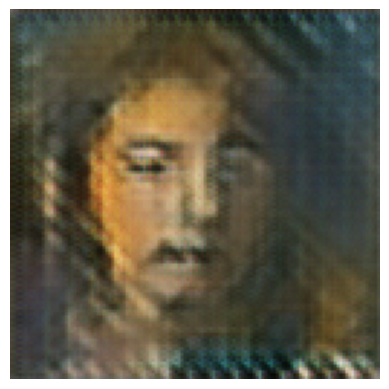

2/2 [==============================] - 0s 13ms/step
Epoch 12/25, Batch 1/48, d=0.433 g=1.233
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 2/48, d=0.441 g=1.497
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 3/48, d=0.410 g=1.507
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 4/48, d=0.344 g=1.518
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 5/48, d=0.398 g=1.562
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 6/48, d=0.505 g=1.016
2/2 [==============================] - 0s 13ms/step
Epoch 12/25, Batch 7/48, d=0.494 g=2.037
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 8/48, d=0.452 g=1.137
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 9/48, d=0.476 g=1.169
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batch 10/48, d=0.455 g=1.432
2/2 [==============================] - 0s 14ms/step
Epoch 12/25, Batc

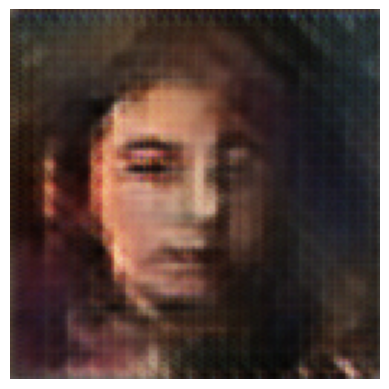

2/2 [==============================] - 0s 15ms/step
Epoch 13/25, Batch 1/48, d=0.499 g=2.154
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 2/48, d=0.544 g=1.046
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 3/48, d=0.520 g=1.639
2/2 [==============================] - 0s 13ms/step
Epoch 13/25, Batch 4/48, d=0.518 g=1.488
2/2 [==============================] - 0s 13ms/step
Epoch 13/25, Batch 5/48, d=0.550 g=0.897
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 6/48, d=0.576 g=1.830
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 7/48, d=0.602 g=1.256
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 8/48, d=0.464 g=0.982
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batch 9/48, d=0.504 g=1.960
2/2 [==============================] - 0s 13ms/step
Epoch 13/25, Batch 10/48, d=0.611 g=1.200
2/2 [==============================] - 0s 14ms/step
Epoch 13/25, Batc

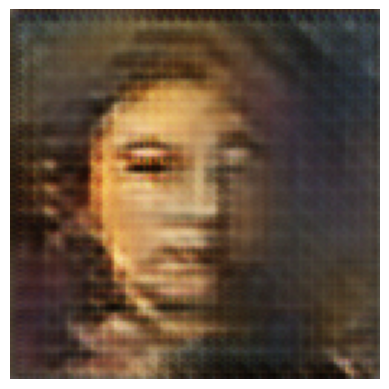

2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 1/48, d=0.537 g=1.178
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 2/48, d=0.449 g=1.807
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 3/48, d=0.383 g=1.723
2/2 [==============================] - 0s 17ms/step
Epoch 14/25, Batch 4/48, d=0.351 g=2.019
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 5/48, d=0.346 g=1.816
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 6/48, d=0.376 g=1.321
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 7/48, d=0.442 g=2.639
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 8/48, d=0.667 g=0.857
2/2 [==============================] - 0s 17ms/step
Epoch 14/25, Batch 9/48, d=0.520 g=1.612
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batch 10/48, d=0.448 g=1.453
2/2 [==============================] - 0s 14ms/step
Epoch 14/25, Batc

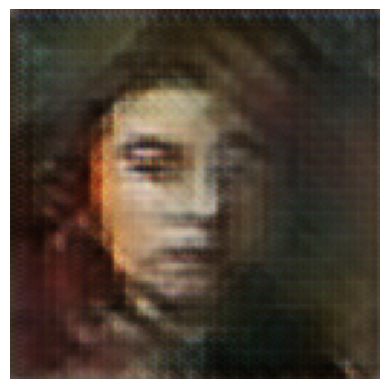

2/2 [==============================] - 0s 13ms/step
Epoch 15/25, Batch 1/48, d=0.467 g=1.318
2/2 [==============================] - 0s 17ms/step
Epoch 15/25, Batch 2/48, d=0.500 g=1.196
2/2 [==============================] - 0s 13ms/step
Epoch 15/25, Batch 3/48, d=0.489 g=1.249
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 4/48, d=0.446 g=1.355
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 5/48, d=0.467 g=1.260
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 6/48, d=0.486 g=1.218
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 7/48, d=0.551 g=1.246
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 8/48, d=0.536 g=1.186
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 9/48, d=0.536 g=1.225
2/2 [==============================] - 0s 14ms/step
Epoch 15/25, Batch 10/48, d=0.558 g=1.032
2/2 [==============================] - 0s 13ms/step
Epoch 15/25, Batc

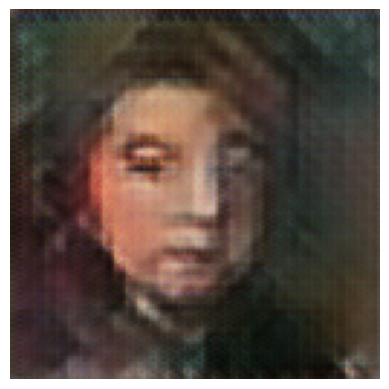

2/2 [==============================] - 0s 13ms/step
Epoch 16/25, Batch 1/48, d=0.521 g=1.263
2/2 [==============================] - 0s 13ms/step
Epoch 16/25, Batch 2/48, d=0.459 g=1.196
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 3/48, d=0.423 g=1.400
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 4/48, d=0.453 g=1.046
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 5/48, d=0.447 g=1.506
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 6/48, d=0.427 g=1.461
2/2 [==============================] - 0s 13ms/step
Epoch 16/25, Batch 7/48, d=0.403 g=1.352
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 8/48, d=0.420 g=1.511
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batch 9/48, d=0.444 g=1.593
2/2 [==============================] - 0s 13ms/step
Epoch 16/25, Batch 10/48, d=0.532 g=1.064
2/2 [==============================] - 0s 14ms/step
Epoch 16/25, Batc

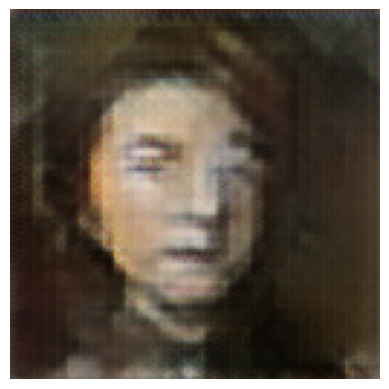

2/2 [==============================] - 0s 13ms/step
Epoch 17/25, Batch 1/48, d=0.438 g=1.590
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 2/48, d=0.492 g=0.805
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 3/48, d=0.529 g=1.266
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 4/48, d=0.475 g=1.547
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 5/48, d=0.551 g=1.190
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 6/48, d=0.568 g=0.856
2/2 [==============================] - 0s 15ms/step
Epoch 17/25, Batch 7/48, d=0.541 g=1.250
2/2 [==============================] - 0s 16ms/step
Epoch 17/25, Batch 8/48, d=0.542 g=1.069
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 9/48, d=0.545 g=1.012
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batch 10/48, d=0.501 g=1.206
2/2 [==============================] - 0s 14ms/step
Epoch 17/25, Batc

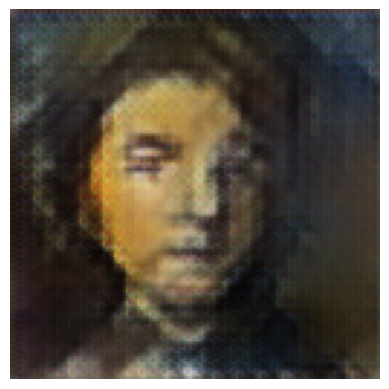

2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 1/48, d=0.628 g=2.501
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 2/48, d=0.739 g=1.411
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 3/48, d=0.453 g=0.833
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 4/48, d=0.556 g=1.532
2/2 [==============================] - 0s 13ms/step
Epoch 18/25, Batch 5/48, d=0.479 g=1.696
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 6/48, d=0.457 g=1.212
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 7/48, d=0.487 g=1.112
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 8/48, d=0.441 g=1.172
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 9/48, d=0.453 g=1.260
2/2 [==============================] - 0s 14ms/step
Epoch 18/25, Batch 10/48, d=0.438 g=1.206
2/2 [==============================] - 0s 15ms/step
Epoch 18/25, Batc

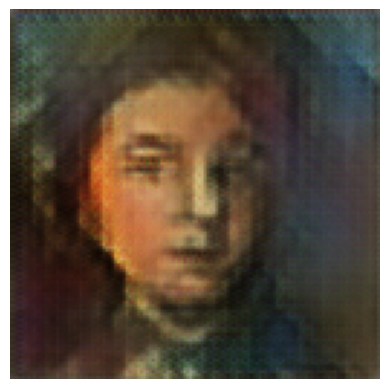

2/2 [==============================] - 0s 13ms/step
Epoch 19/25, Batch 1/48, d=0.462 g=1.565
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 2/48, d=0.367 g=1.243
2/2 [==============================] - 0s 13ms/step
Epoch 19/25, Batch 3/48, d=0.512 g=0.949
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 4/48, d=0.543 g=2.265
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 5/48, d=0.607 g=0.862
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 6/48, d=0.610 g=1.941
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 7/48, d=0.659 g=1.105
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 8/48, d=0.650 g=1.214
2/2 [==============================] - 0s 14ms/step
Epoch 19/25, Batch 9/48, d=0.565 g=1.501
2/2 [==============================] - 0s 13ms/step
Epoch 19/25, Batch 10/48, d=0.653 g=1.194
2/2 [==============================] - 0s 13ms/step
Epoch 19/25, Batc

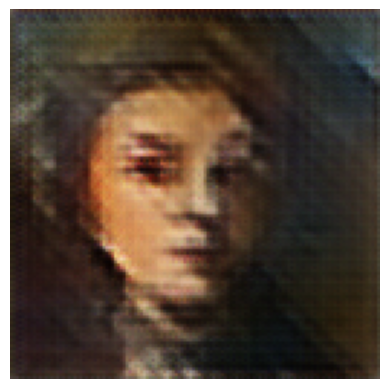

2/2 [==============================] - 0s 13ms/step
Epoch 20/25, Batch 1/48, d=0.494 g=1.353
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 2/48, d=0.540 g=1.335
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 3/48, d=0.456 g=1.325
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 4/48, d=0.411 g=1.436
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 5/48, d=0.444 g=1.289
2/2 [==============================] - 0s 17ms/step
Epoch 20/25, Batch 6/48, d=0.402 g=1.856
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 7/48, d=0.425 g=1.259
2/2 [==============================] - 0s 15ms/step
Epoch 20/25, Batch 8/48, d=0.408 g=2.063
2/2 [==============================] - 0s 13ms/step
Epoch 20/25, Batch 9/48, d=0.427 g=0.982
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batch 10/48, d=0.626 g=3.433
2/2 [==============================] - 0s 14ms/step
Epoch 20/25, Batc

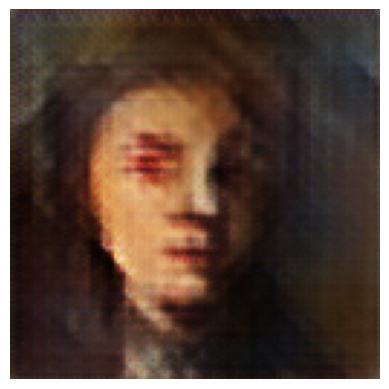

2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 1/48, d=0.434 g=2.717
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 2/48, d=0.699 g=0.813
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 3/48, d=0.573 g=2.369
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 4/48, d=0.662 g=1.375
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 5/48, d=0.491 g=1.086
2/2 [==============================] - 0s 13ms/step
Epoch 21/25, Batch 6/48, d=0.599 g=1.198
2/2 [==============================] - 0s 11ms/step
Epoch 21/25, Batch 7/48, d=0.573 g=1.288
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 8/48, d=0.576 g=1.180
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 9/48, d=0.525 g=1.270
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batch 10/48, d=0.532 g=1.319
2/2 [==============================] - 0s 14ms/step
Epoch 21/25, Batc

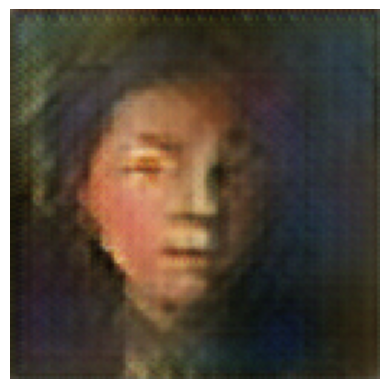

2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 1/48, d=0.445 g=1.146
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 2/48, d=0.428 g=1.395
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 3/48, d=0.352 g=1.618
2/2 [==============================] - 0s 15ms/step
Epoch 22/25, Batch 4/48, d=0.439 g=1.165
2/2 [==============================] - 0s 13ms/step
Epoch 22/25, Batch 5/48, d=0.398 g=1.499
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 6/48, d=0.389 g=1.675
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 7/48, d=0.392 g=1.251
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 8/48, d=0.420 g=1.842
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 9/48, d=0.501 g=1.208
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batch 10/48, d=0.481 g=1.333
2/2 [==============================] - 0s 14ms/step
Epoch 22/25, Batc

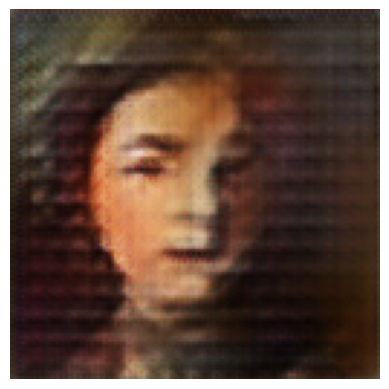

2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 1/48, d=0.481 g=2.232
2/2 [==============================] - 0s 13ms/step
Epoch 23/25, Batch 2/48, d=0.562 g=1.315
2/2 [==============================] - 0s 13ms/step
Epoch 23/25, Batch 3/48, d=0.604 g=1.804
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 4/48, d=0.402 g=1.937
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 5/48, d=0.453 g=1.404
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 6/48, d=0.467 g=1.412
2/2 [==============================] - 0s 17ms/step
Epoch 23/25, Batch 7/48, d=0.426 g=1.561
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 8/48, d=0.426 g=1.300
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batch 9/48, d=0.428 g=1.632
2/2 [==============================] - 0s 13ms/step
Epoch 23/25, Batch 10/48, d=0.433 g=1.454
2/2 [==============================] - 0s 14ms/step
Epoch 23/25, Batc

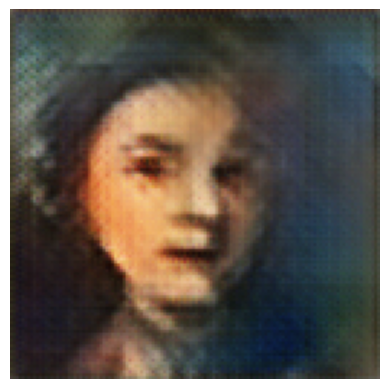

2/2 [==============================] - 0s 16ms/step
Epoch 24/25, Batch 1/48, d=0.573 g=0.967
2/2 [==============================] - 0s 13ms/step
Epoch 24/25, Batch 2/48, d=0.574 g=2.346
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 3/48, d=0.676 g=0.663
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 4/48, d=0.639 g=2.414
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 5/48, d=0.733 g=1.184
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 6/48, d=0.542 g=1.097
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 7/48, d=0.503 g=1.423
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 8/48, d=0.474 g=1.289
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batch 9/48, d=0.524 g=1.181
2/2 [==============================] - 0s 13ms/step
Epoch 24/25, Batch 10/48, d=0.458 g=1.553
2/2 [==============================] - 0s 14ms/step
Epoch 24/25, Batc

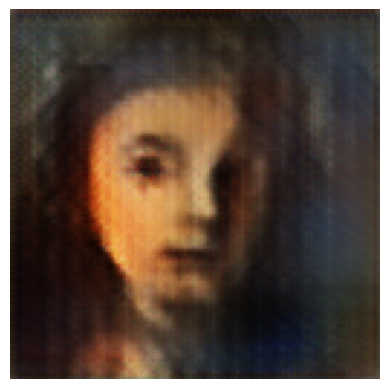

2/2 [==============================] - 0s 13ms/step
Epoch 25/25, Batch 1/48, d=0.507 g=1.226
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 2/48, d=0.472 g=1.091
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 3/48, d=0.551 g=1.170
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 4/48, d=0.529 g=1.541
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 5/48, d=0.535 g=1.367
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 6/48, d=0.453 g=1.321
2/2 [==============================] - 0s 13ms/step
Epoch 25/25, Batch 7/48, d=0.474 g=1.320
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 8/48, d=0.417 g=1.455
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 9/48, d=0.405 g=1.629
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batch 10/48, d=0.469 g=1.450
2/2 [==============================] - 0s 14ms/step
Epoch 25/25, Batc

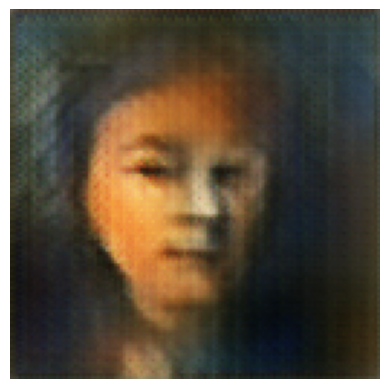

In [58]:
d_loss,g_loss=train(generator,discriminator,dcgan,images,latent_dim,epoch,batch_size,vec0)

In [59]:
img=generator.predict(vec0)

1/1 [==============================] - 0s 17ms/step


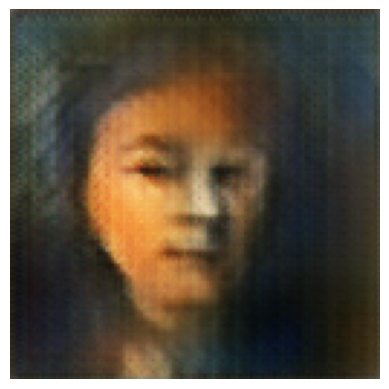

In [60]:
plt.imshow((np.array(img[0])+1)/2)
plt.axis('off')
plt.show()

In [61]:
num_images=16
x_gen=generate_latent_points(latent_dim,num_images)
gen_images=generator.predict(x_gen) # generating 16 images

1/1 [==============================] - 0s 20ms/step


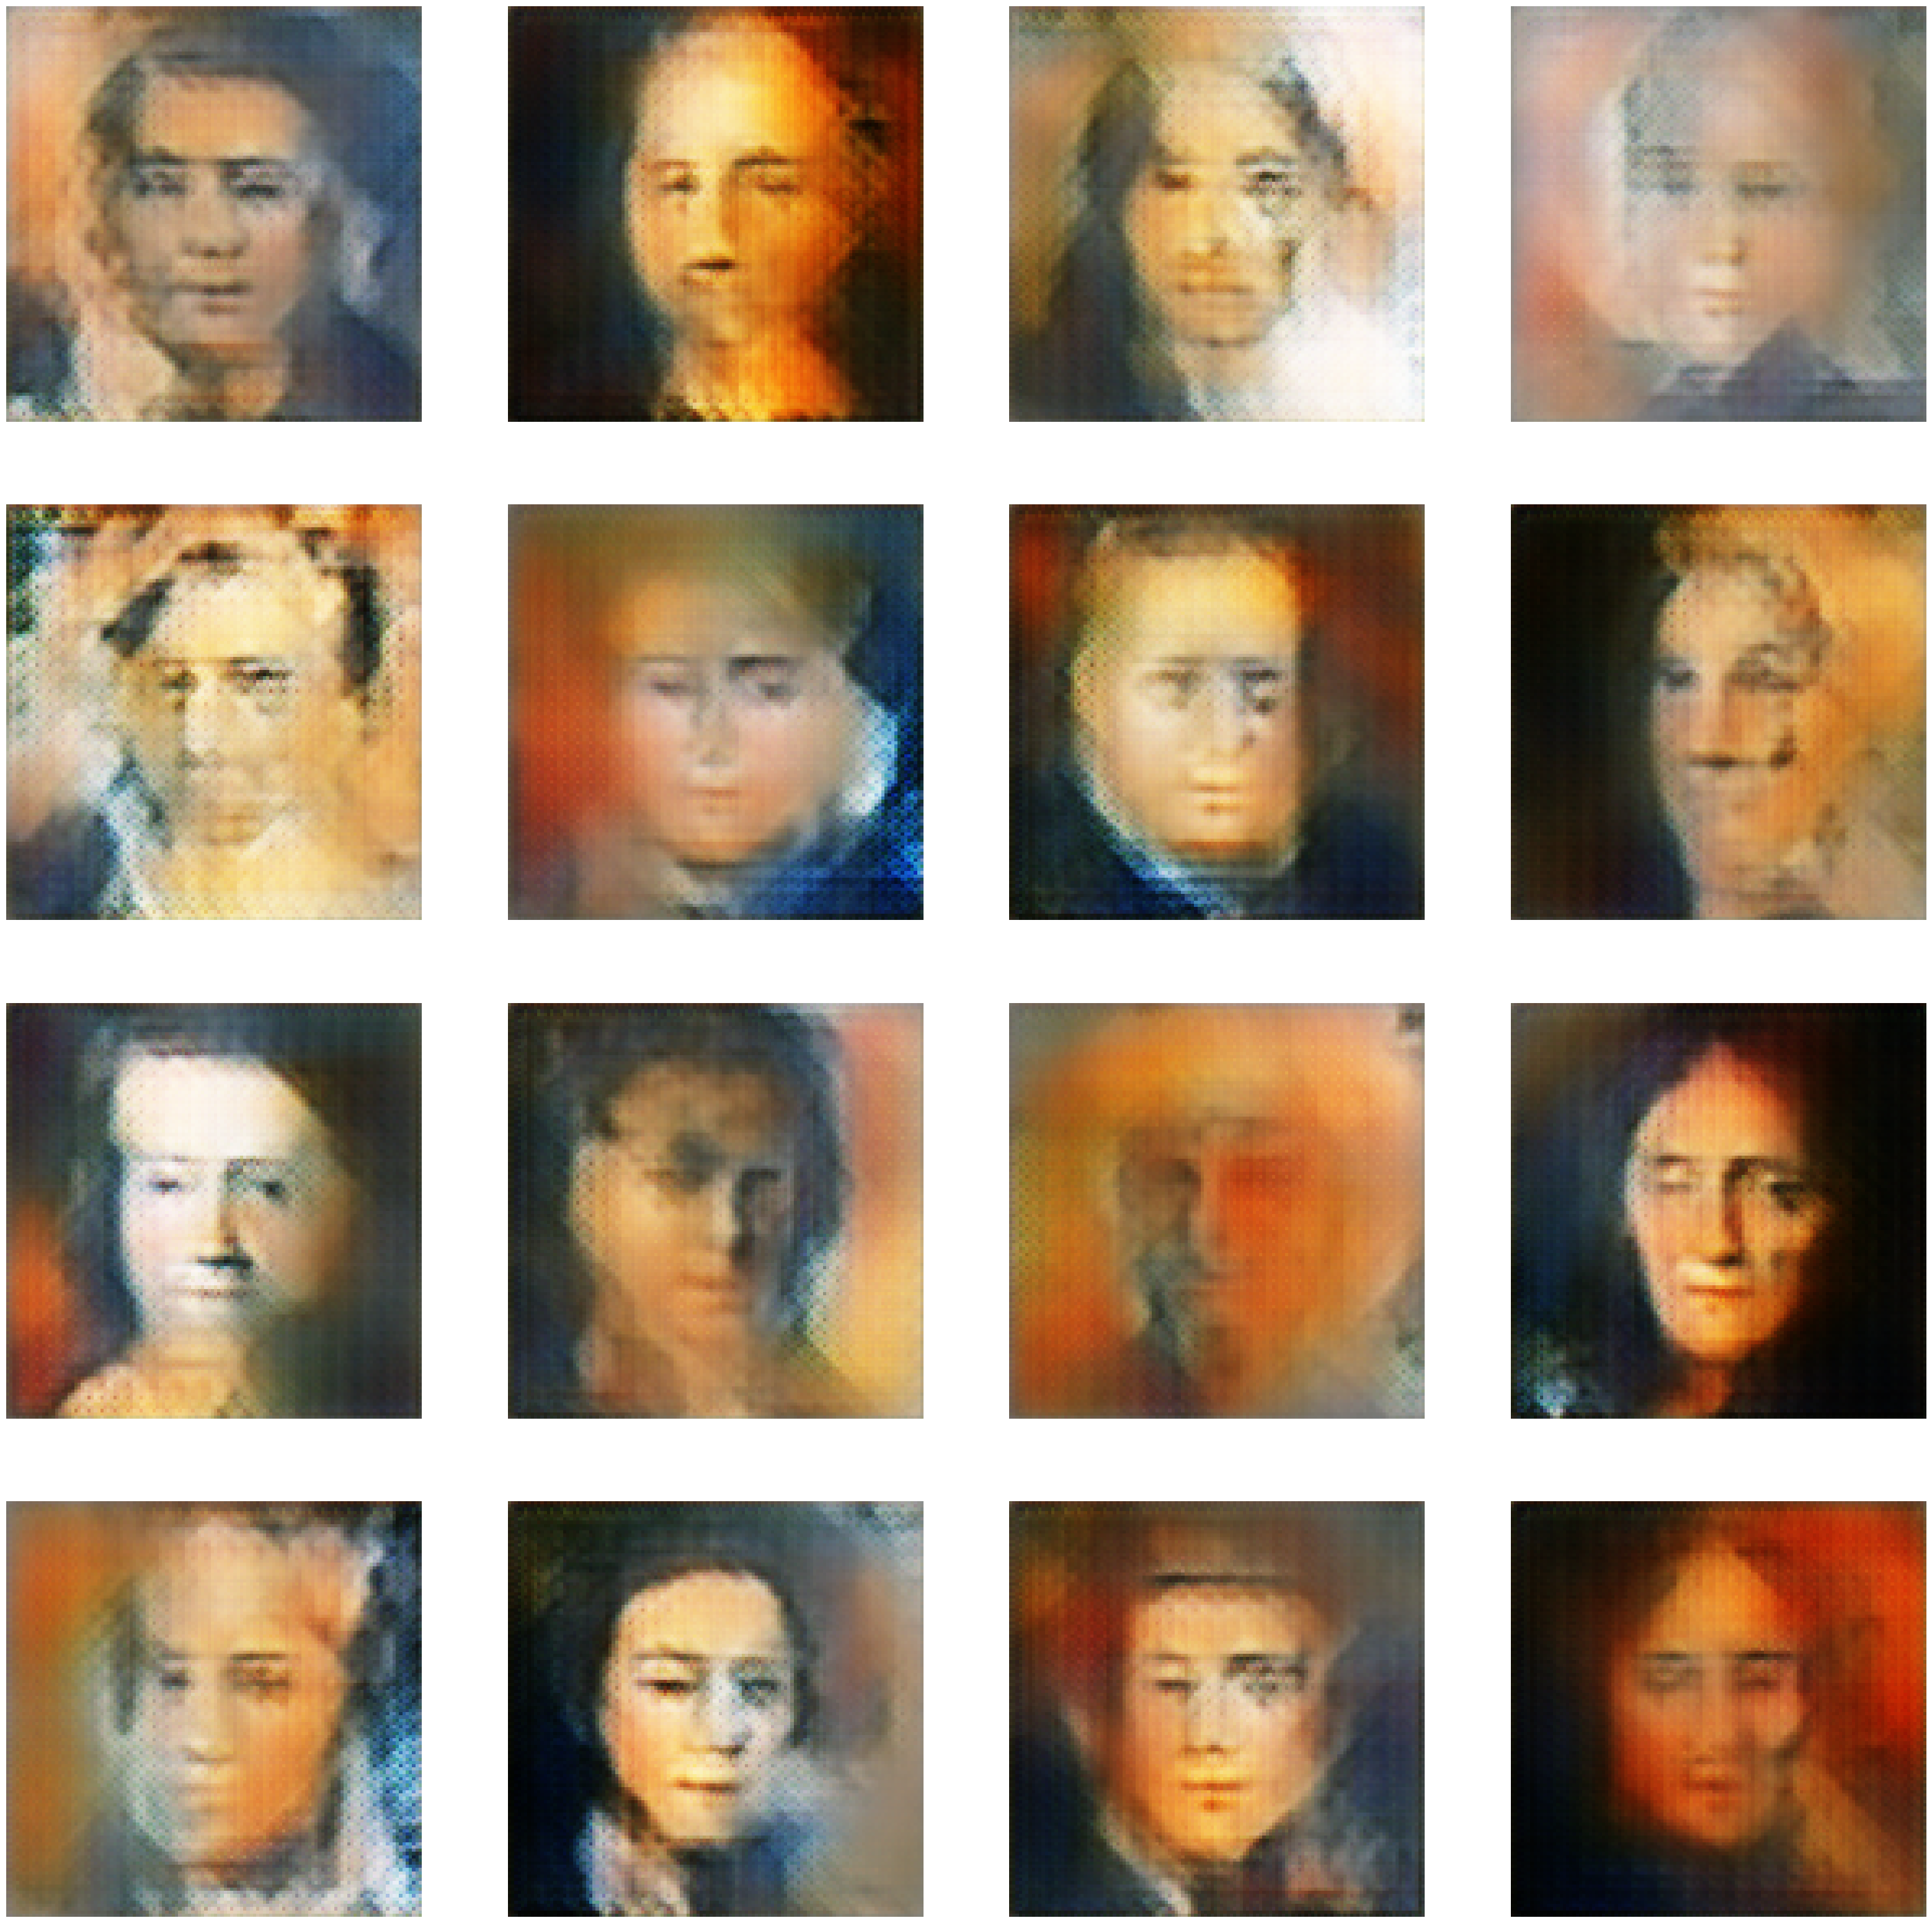

In [62]:
plt.figure(figsize=(40,40))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow((gen_images[i]+1)/2)
plt.show()

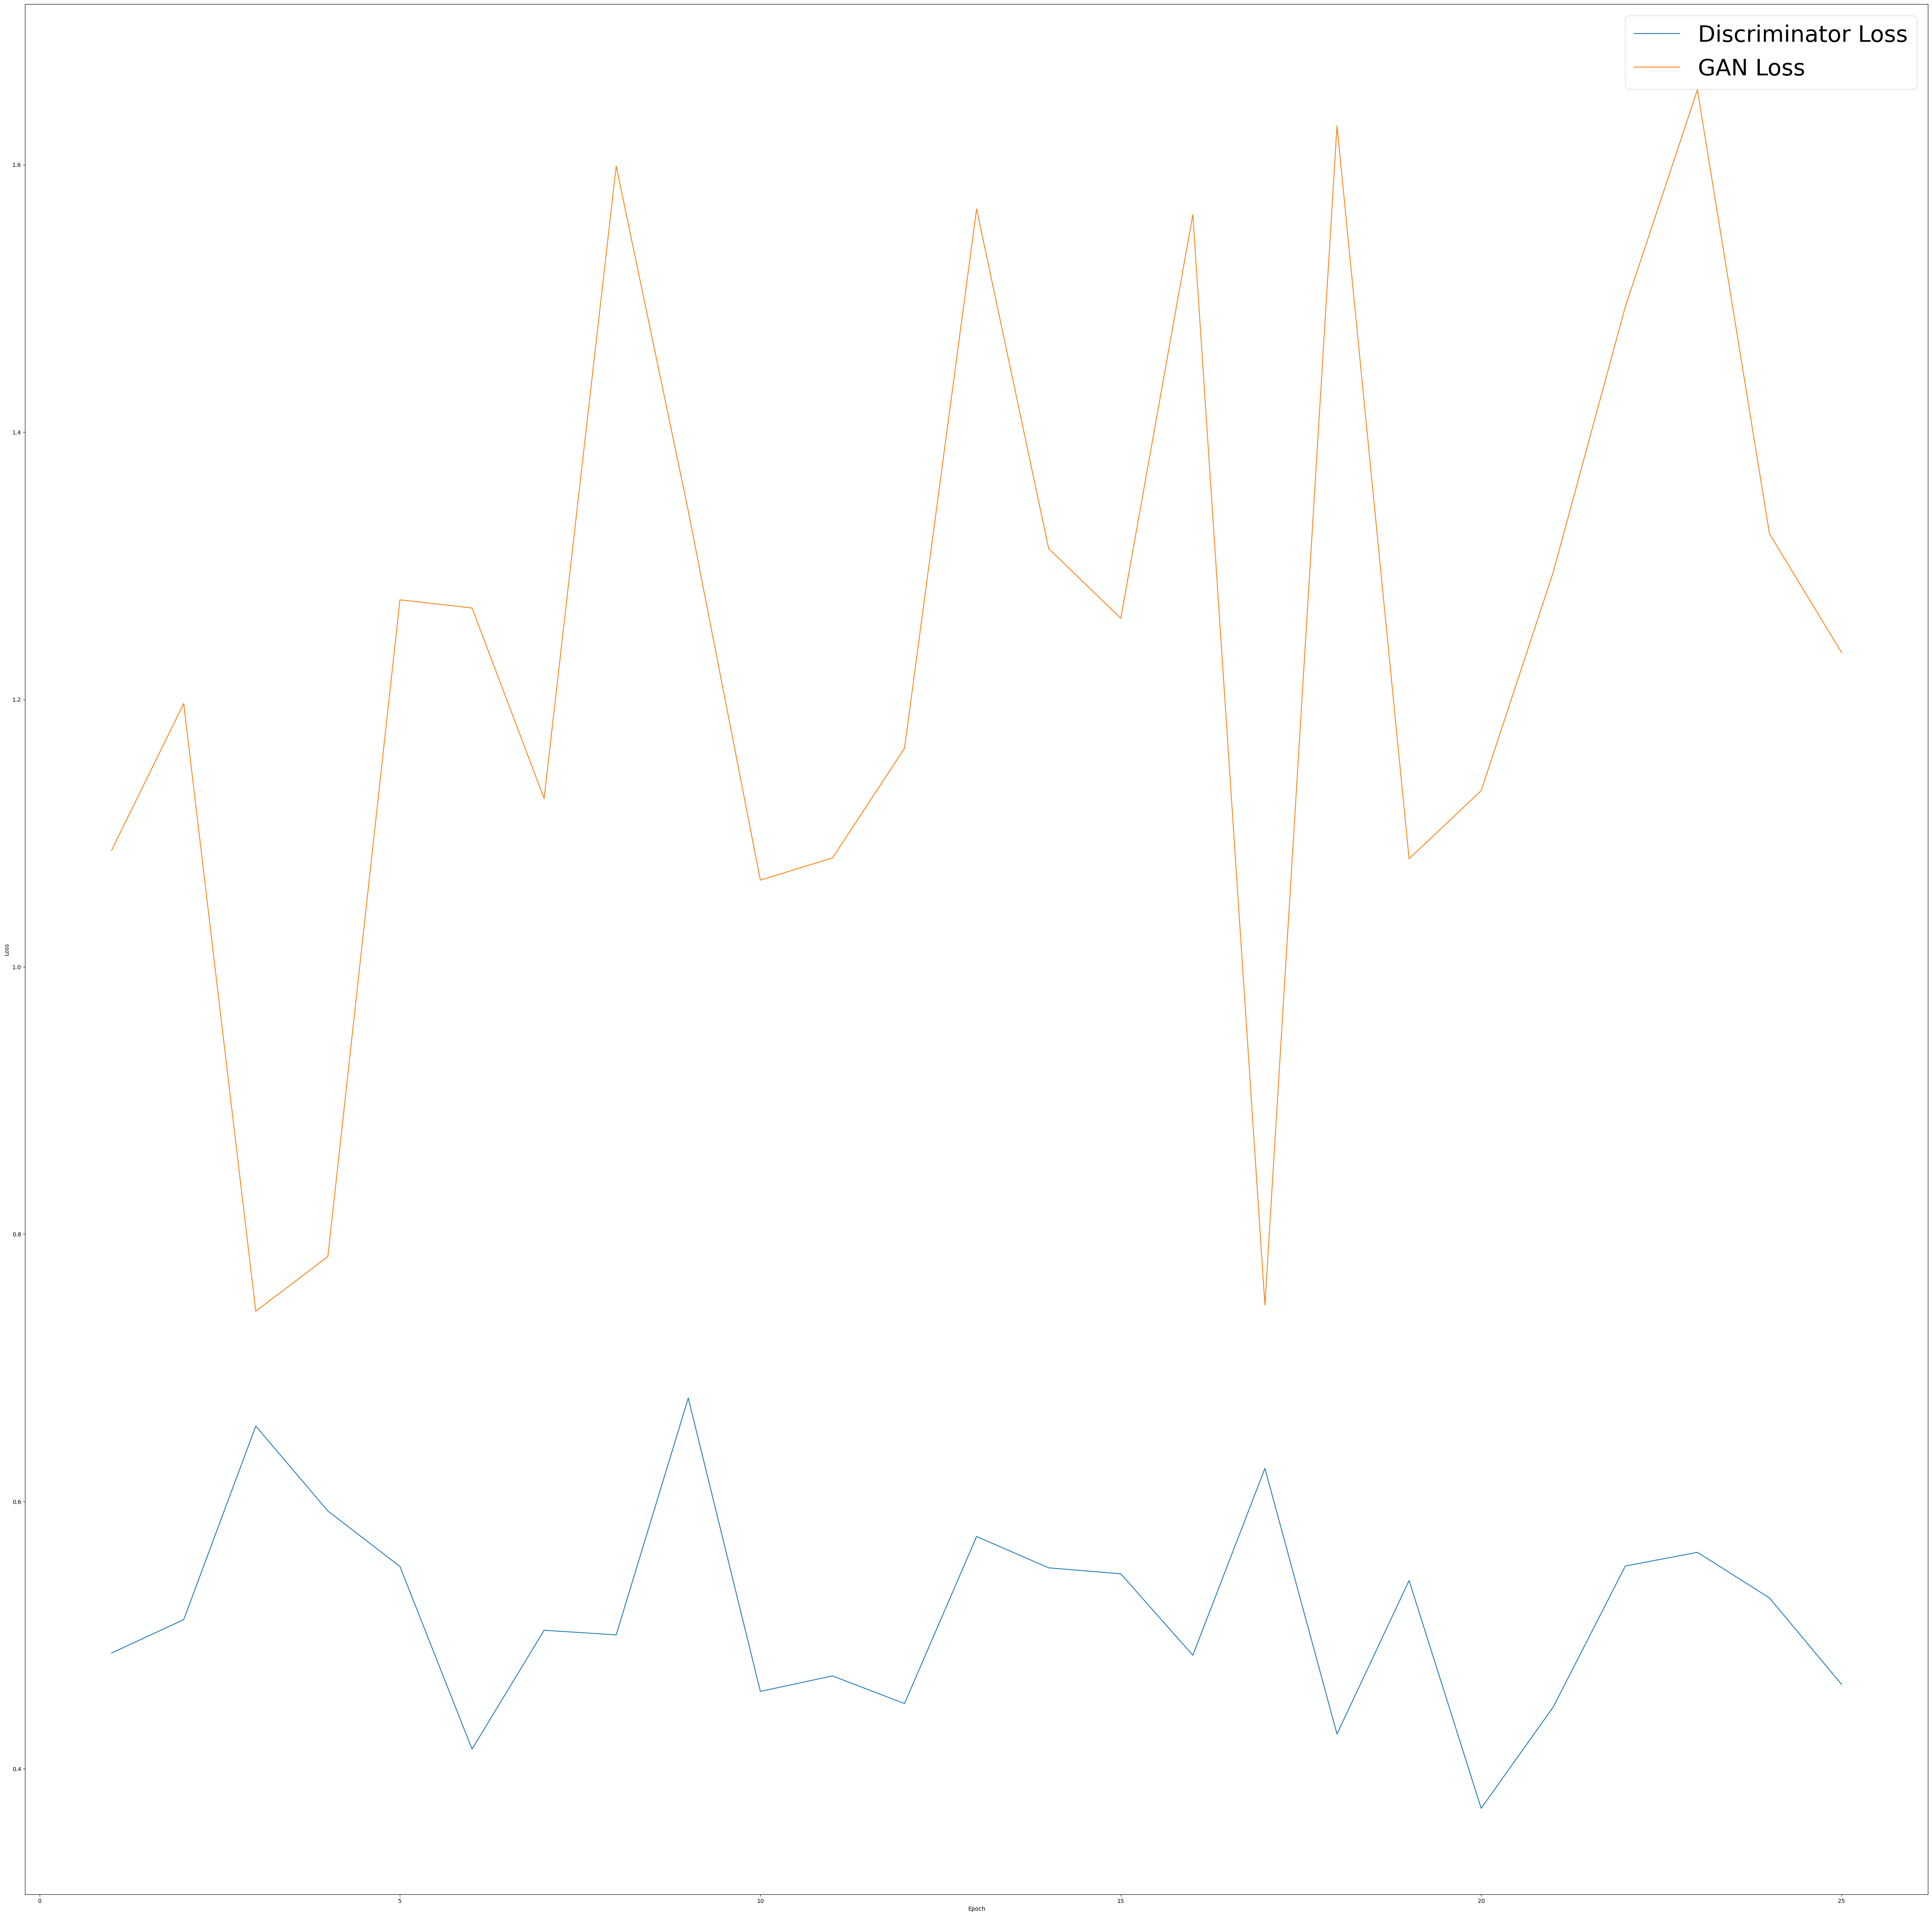

In [64]:
x=np.arange(1,epoch+1)
plt.figure(figsize=(60,60))
plt.plot(x,d_loss,label='Discriminator Loss')
plt.plot(x,g_loss,label='GAN Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=40)
plt.show()